In [ ]:
#track top left corner of the DL mask and see how it rotates
#revert the DL crop back to the original DL mask (size, orientation...)
#1.rotate DL mask
#we want to paste the crop back on the dl mask
#

In [ ]:
#cv2 bitwise_or
#only works on images with the same dimension, it overlaps the images

# paste image by centroid
# might need the mask again.
# we can try to calculate the difference between the new centroid and the original centroid

In [ ]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [ ]:
def rotate_image_cv2(mat, angle,is_mask):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    return rotated_mat

In [ ]:
src = r"\\fatherserverdw\kyuex\clue images\1um"
dst = os.path.join(src, 'classification_v9_combined\crop_TA\crop_HE_DL')

In [ ]:

degrot_LUT = pd.read_csv(r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\new_CLUEdegrot.csv")

In [ ]:
degrot_LUT

In [ ]:
LUT = degrot_LUT.iloc[0]

imname = LUT['imname']
imID = LUT['imID']
degrot =  LUT['degrot']
sec = LUT['secN']
cent = LUT['centroid']


In [ ]:


mask_path = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\{}.tif".format(imname)
mask = Image.open(mask_path)
im_path =  r"\\fatherserverdw\kyuex\clue images\1um\{}.tif".format(imname)
im = Image.open(im_path)

In [ ]:
DLcrop_pth = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\im\{}.png".format(imname + '_sec01')
DLcrop = Image.open(DLcrop_pth)

#the mask and the image are not the same size
DLmask_pth =  r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\mask\{}.png".format(imname + '_sec01')
DLmask = Image.open(DLmask_pth)

DLmsk_arr = np.array(DLmask)


In [ ]:
if(DLmask.size != DLcrop.size):
    new_msk = np.zeros((DLcrop.size[1],DLcrop.size[0]))

    #change this to be more efficient (copy larger image onto a smaller image
    for i in range(0,DLmsk_arr.shape[0]):
         for k in range(0,DLmsk_arr.shape[1]):
           new_msk[i,k] = DLmsk_arr[i,k]


In [ ]:
#size of original whole-slide image
h,w = im.size


In [ ]:
#the section ids  don't matter because i just want ones and zeros
new_msk[new_msk == 0] = 1
new_msk[new_msk == 12] = 0

In [ ]:
#rotate crop back to original orientation
im_rot = rotate_image_cv2(np.array(DLcrop), -degrot,False)

#weird line on the image
msk_rot = rotate_image_cv2(new_msk.astype('uint8'), -degrot,True)

In [ ]:
plt.imshow(msk_rot)

In [ ]:

[xt, yt] = np.where(msk_rot != 0) #tissue mask to point clouds,don't know why there are three arrays
mskcrop = msk_rot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]

In [ ]:
msk_rot

In [ ]:
np.min(yt)

In [ ]:
mskcrop.shape

In [ ]:
msk_rot.shape

In [ ]:
(w,h)

In [ ]:
plt.imshow(mskcrop)

In [ ]:
msk_rot[msk_rot == 0] = 1
msk_rot[msk_rot == 12] = 0
msk_rot[msk_rot != 0] = 1

In [ ]:
empty = np.zeros((w,h)).astype('bool')

In [ ]:
msk_crop =

In [3]:
#cv2 bitwise_or
#only works on images with the same dimension, it overlaps the images

# paste image by centroid
# might need the mask again.
# we can try to calculate the difference between the new centroid and the original centroid

In [4]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [251]:
def rotate_image_cv2(mat, angle,is_mask):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))

    return rotated_mat

In [252]:
src = r"\\fatherserverdw\kyuex\clue images\1um"
dst = os.path.join(src, 'classification_v9_combined\crop_TA\crop_HE_DL')

In [253]:

degrot_LUT = pd.read_csv(r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\new_CLUEdegrot.csv")

In [254]:
degrot_LUT

,Unnamed: 0.1,Unnamed: 0,imID,imname,secN,k,degrot,centroid
0,0,0,0,2022-06-07 14.27.44,1,[ 0.33982065 0.94049026 -0.94049026 0.33982065],160.13,"(9319.690124103598, 8086.429334669696)"
1,1,1,1,2022-06-07 14.32.24,1,[-0.13191004 -0.99126169 0.99126169 -0.13191004],352.42,"(14333.236200958356, 5900.067819168355)"
2,2,2,2,2022-06-07 14.34.59,1,[ 0.31836081 0.94796962 -0.94796962 0.31836081],161.44,"(9890.519811487757, 5622.40267381882)"
3,3,3,3,2022-06-07 14.37.19,1,[-0.53153658 -0.84703534 0.84703534 -0.53153658],327.89,"(8653.761477488122, 4747.436996898308)"
4,4,4,4,2022-06-07 16.13.52,1,[ 0.38013247 0.92493205 0.92493205 -0.38013247],22.34,"(11372.527128647533, 5030.097351796957)"
5,5,5,4,2022-06-07 16.13.52,2,[ 0.4366632 0.89962506 0.89962506 -0.4366632 ],25.89,"(25698.40520889134, 6008.134870711241)"
6,6,6,4,2022-06-07 16.13.52,3,[ 0.38595748 0.92251657 0.92251657 -0.38595748],22.70,"(9569.144164100746, 12781.550714150342)"
7,7,7,4,2022-06-07 16.13.52,4,[-0.25799689 -0.96614575 -0.96614575 0.25799689],194.95,"(25412.454828099595, 14437.731346141207)"
8,8,8,5,2022-06-07 17.24.15,1,[ 0.44819642 0.8939351 0.8939351 -0.44819642],26.63,"(12316.50920598856, 4217.289909522457)"
9,9,9,5,2022-06-07 17.24.15,2,[ 0.48687151 0.8734736 0.8734736 -0.48687151],29.14,"(6811.3017028114955, 10162.077581167496)"


In [255]:
LUT = degrot_LUT.iloc[0]

imname = LUT['imname']
imID = LUT['imID']
degrot =  LUT['degrot']
sec = LUT['secN']
cent = LUT['centroid']


In [256]:


mask_path = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\{}.tif".format(imname)
mask = Image.open(mask_path)
im_path =  r"\\fatherserverdw\kyuex\clue images\1um\{}.tif".format(imname)
im = Image.open(im_path)

In [260]:
DLcrop_pth = r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\im\{}.png".format(imname + '_sec01')
DLcrop = Image.open(DLcrop_pth)

#the mask and the image are not the same size
DLmask_pth =  r"\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined\crop_TA\crop_HE_DL\mask\{}.png".format(imname + '_sec01')
DLmask = Image.open(DLmask_pth)

DLmsk_arr = np.array(DLmask)


In [261]:
if(DLmask.size != DLcrop.size):
    new_msk = np.zeros((DLcrop.size[1],DLcrop.size[0]))

    #change this to be more efficient (copy larger image onto a smaller image
    for i in range(0,DLmsk_arr.shape[0]):
         for k in range(0,DLmsk_arr.shape[1]):
           new_msk[i,k] = DLmsk_arr[i,k]


In [262]:
#size of original whole-slide image
h,w = im.size


In [263]:
#the section ids  don't matter because i just want ones and zeros
new_msk[new_msk == 0] = 1
new_msk[new_msk == 12] = 0

In [264]:
#rotate crop back to original orientation
im_rot = rotate_image_cv2(np.array(DLcrop), -degrot,False)

#weird line on the image
msk_rot = rotate_image_cv2(new_msk.astype('uint8'), -degrot,True)

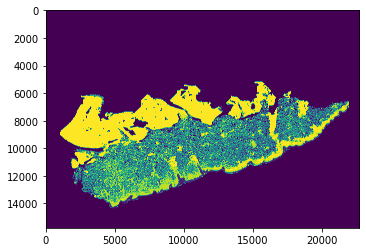

In [268]:
plt.imshow(msk_rot)

In [283]:

[xt, yt] = np.where(msk_rot != 0) #tissue mask to point clouds,don't know why there are three arrays
mskcrop = msk_rot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]

In [277]:
msk_rot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [272]:
np.min(yt)

1

In [269]:
mskcrop.shape

(14336, 21948)

In [270]:
msk_rot.shape

(15766, 22721)

In [271]:
(w,h)

(14301, 21196)

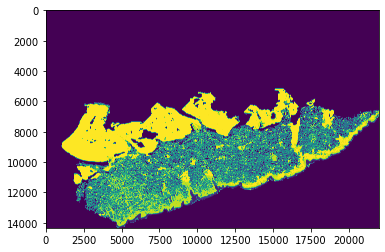

In [284]:
plt.imshow(mskcrop)

In [229]:
msk_rot[msk_rot == 0] = 1
msk_rot[msk_rot == 12] = 0
msk_rot[msk_rot != 0] = 1

In [237]:
empty = np.zeros((w,h)).astype('bool')

In [ ]:
msk_crop =